# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [1]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master
!pip install geopandas

In [2]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)

In [3]:
import os

import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [5]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [6]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


In [7]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/employment_and_support_allowance"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

Downloads
--

[Dataset: Employment and Support Allowance (ESA)](https://stat-xplore.dwp.gov.uk/webapi/metadata/ESA_Caseload_new/ESA_Caseload_new.html)

```
 Dataset: Employment and Supprt Allowance (ESA) Caseload

Description

Employment and Support Allowance (ESA) offers financial support and personalised support to those who are unable to work as a result of a health condition or disability. You may be eligible for ESA if you are under State Pension age, not getting Statutory Sick Pay or Maternity Pay, or are not getting Jobseeker’s Allowance. If eligible, when a new claimant applies for ESA they will enter an assessment phase which usually lasts for 13 weeks. During this phase the claimant will have their ability to work assessed to determine their entitlement, this is called the Work Capability Assessment (WCA).

During the assessment phase the claimant will be paid at the ‘assessment rate’ which is based on the Jobseeker's Allowance personal allowance (subject to customers satisfying the relevant contribution condition and/or income tests).

Recording and clerical errors can occur within the data source - for this reason, no reliance should be placed on very small numbers obtained through Stat-Xplore.

Statistical disclosure control has been applied with Stat-Xplore, which guards against the identification of an individual claimant.


```

In [8]:
def get_data(statxplore_table_config):
    query = f'{output_dir}/{statxplore_table_config}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

In [9]:
# get the data from the statxplore api - this is based on a pre-existing file that sets the parameters to be used
# https://stat-xplore.dwp.gov.uk/webapi/jsf/tableView/tableView.xhtml
df = get_data(statxplore_table_config='table_2021-12-07_22-04-24')

In [10]:
df.head()

,National - Regional - LA - OAs,Quarter,Employment and Support Allowance Caseload - 2011 Geographies
0,England,May-21,1476769.0
1,London,May-21,205937.0
2,Lewisham,May-21,8729.0
3,E00016403,May-21,9.0
4,E00016437,May-21,13.0


## Functions to transform data

In [11]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Quarter` and `National - Regional  - LA - OAs`
  return d[d['Quarter'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [12]:
def format_statxplore_data(d, geo_colname):
  return d.\
           rename(columns={'National - Regional - LA - OAs': geo_colname})

In [13]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list),'OA11CD')

In [14]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, greater_group_table, oa_col, greater_col, group_col):
  return pd.merge(oa_data, greater_group_table, left_on=[oa_col], right_on=[greater_col], how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [15]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [16]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [17]:
epoch = ['May-21']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()

for datname in ['employment_and_support_allowance']:
  IPython.display.display(f"=== {datname} ===")

  # Simplify the column names
  df.columns = df.columns.str.replace(
      # Remove the redundant qualifier suffix
      r'^(.*?) - 2011 Geographies', 
      r'\1')

  # First process the Lewisham subset
  oas = filter_statxplore_data(df,epoch,lbl_oa_list)
  
  # Transform to OA index data
  lbl_oa = statxplore_to_oa(oas, epoch, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_lsoa_join, oa_col="OA11CD", greater_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_wd22_join, oa_col="OA11CD", greater_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Aggregate to London level  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())



'=== employment_and_support_allowance ==='

,OA11CD,Quarter,Employment and Support Allowance Caseload
3,E00016403,May-21,9.0
4,E00016437,May-21,13.0
5,E00016439,May-21,29.0
6,E00016442,May-21,9.0
7,E00016399,May-21,18.0


,Employment and Support Allowance Caseload
LSOA11CD,
E01003189,98.0
E01003190,91.0
E01003191,54.0
E01003192,111.0
E01003193,54.0


,Employment and Support Allowance Caseload
WD22CD_proposed,
E05013714,571.0
E05013715,416.0
E05013716,402.0
E05013717,456.0
E05013718,326.0


,Name,Quarter,Employment and Support Allowance Caseload
0,England,May-21,1476769.0
1,London,May-21,205937.0
2,Lewisham,May-21,8729.0


Relative numbers
--

In [ ]:
# TODO: we need to get a population total to compute this
# Need to review StatXplore methodology to see what their population sample basis is

## Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
education_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')

# Output

No handles with labels found to put in legend.


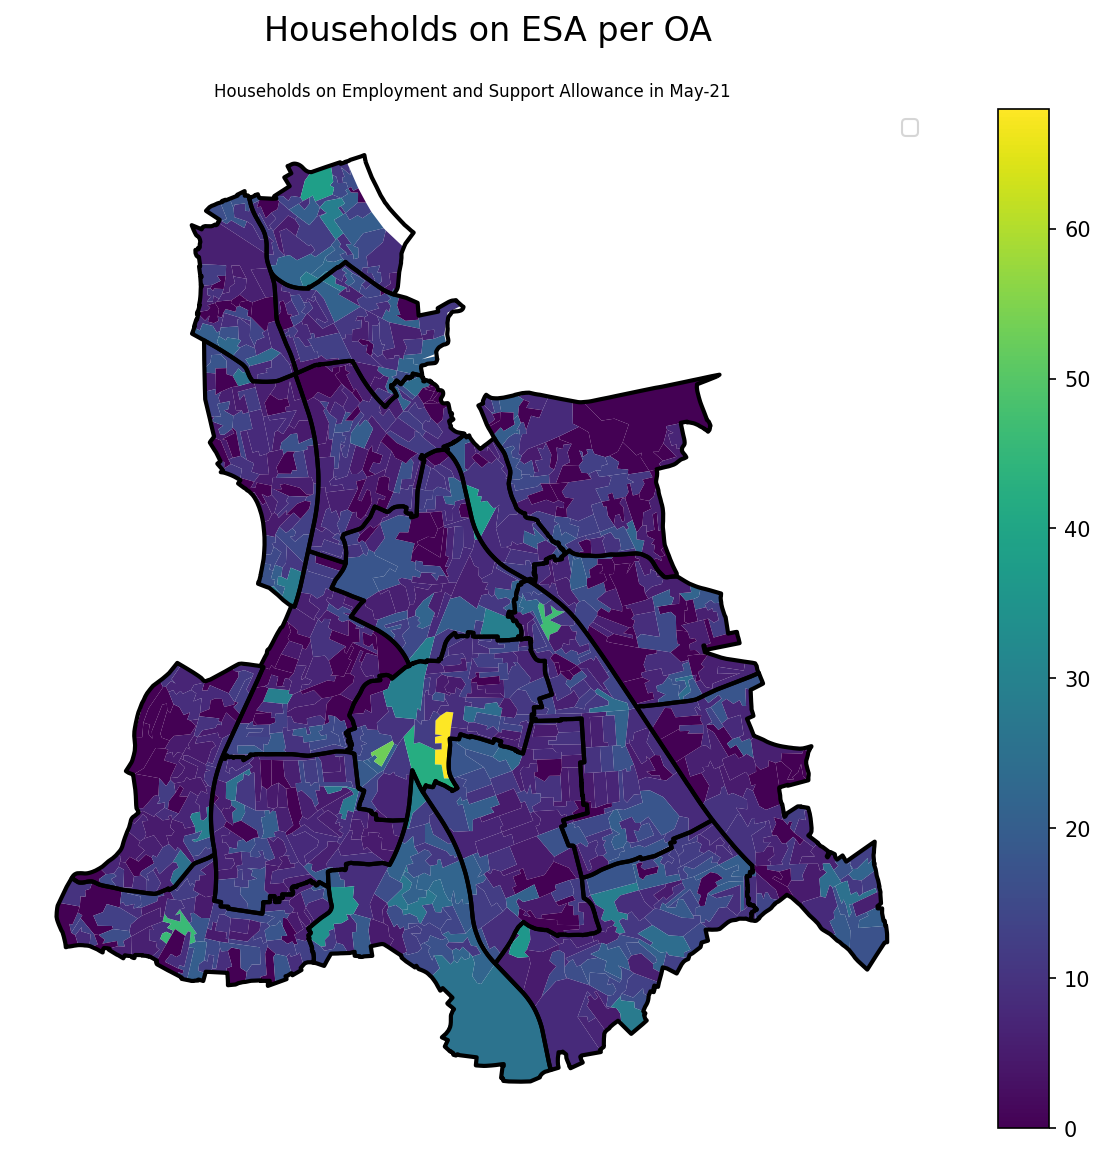

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on ESA per OA', fontsize=16, y=.95)
plt.title('Households on Employment and Support Allowance in '+epoch[0], fontsize=8)
education_oa_geom.plot(ax=ax, column="Employment and Support Allowance Caseload", legend=True)
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.axis('off')

plt.savefig(f"{output_dir}/lbl_oa11_jsa.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_jsa.pdf")